In [9]:
import azureml.core
import logging

print("SDK version:", azureml.core.VERSION)

from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)

import os
subscription_id = os.getenv("SUBSCRIPTION_ID", default="52f3cf55-fed4-4f7e-9aca-f3da535a03c1")
resource_group = os.getenv("RESOURCE_GROUP", default="automl_rg")
workspace_name = os.getenv("WORKSPACE_NAME", default="automl_ws")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")


from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

try:
    interactive_auth = InteractiveLoginAuthentication(tenant_id="1591aa04-9c2a-4144-9a04-fb8b0d506de5")
    ws = Workspace(subscription_id = subscription_id, 
               resource_group = resource_group, 
               workspace_name = workspace_name,
               auth=interactive_auth)    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded.")
except:
    print("Workspace not accessible.")



SDK version: 1.0.45
Turning diagnostics collection on. 
Workspace configuration succeeded.


In [18]:
datasetAlgo_runid={"H_eclipse_2_0_randomforest":"H_eclipse_2_0_randomforest_1561750627559"
,"H_prop_2_randomforest":"H_prop_2_randomforest_1561752068253"
,"H_xalan_2_6_randomforest":"H_xalan_2_6_randomforest_1561752155960"
,"H_eclipse_3_0_randomforest":"H_eclipse_3_0_randomforest_1561752028016"
,"H_camel_1_2_randomforest":"H_camel_1_2_randomforest_1561751966406"
,"H_camel_1_2_xgboost":"H_camel_1_2_xgboost_1561759303507"
,"H_eclipse_2_0_xgboost":"H_eclipse_2_0_xgboost_1561759477871"
,"H_eclipse_3_0_xgboost":"H_eclipse_3_0_xgboost_1561759503753"
,"H_prop_2_xgboost":"H_prop_2_xgboost_1561759543033"
,"H_xalan_2_6_xgboost":"H_xalan_2_6_xgboost_1561758985165"
,"H_camel_1_2_logistic_regression":"H_camel_1_2_logistic_regression_1561823575526"
,"H_eclipse_2_0_logistic_regression":"H_eclipse_2_0_logistic_regression_1561830150555"
,"H_eclipse_3_0_logistic_regression":"H_eclipse_3_0_logistic_regression_1561830205392"
,"H_prop_2_logistic_regression":"H_prop_2_logistic_regression_1561830234009"
,"H_xalan_2_6_logistic_regression":"H_xalan_2_6_logistic_regression_1561830262136"}

dataset_list = ["defect_eclipse_2_0",
"defect_camel_1_2",
"defect_eclipse_3_0",
"defect_prop_2",
"defect_xalan_2_6"]

algo_list = ['xgboost','randomforest','logistic_regression']


In [5]:
# Load data
def loadData(dataset_name):
    dataset_file_name = dataset_name+'.csv'
    dataset_path_name = os.path.join(os.getcwd(),'data/'+dataset_name+'.csv' )
    import pandas as pd
    df = pd.read_csv(dataset_path_name)
    x_df = df.drop(columns =['target'])
    y_df = df[['target']]
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)
    # flatten y_train to 1d array
    y_train.values.flatten()# flatten y_train to 1d array
    return x_train, x_test, y_train, y_test

In [22]:
from azureml.widgets import RunDetails
from azureml.core.experiment import Experiment
from azureml.train.hyperdrive import HyperDriveRun
from azureml.core import Workspace
from azureml.core.model import Model

h_run_map={}
h_model_shell_map={}

for dataset in dataset_list:
    for algo in algo_list:
        expname = 'H_'+dataset.split('defect_')[1]+'_'+algo
        #print(expname)
        #print(datasetAlgo_runid[expname])
        experiment=Experiment(ws, expname)
        print(datasetAlgo_runid[expname])
        remote_run = HyperDriveRun(experiment = experiment, run_id =datasetAlgo_runid[expname])
        if algo =='logistic_regression': 
            expname = 'H_'+dataset.split('defect_')[1]+'_lr'
        b_run = remote_run.get_best_run_by_primary_metric()
        h_run_map[expname]=b_run
        b_model = b_run.register_model(model_name =expname, model_path = 'outputs/model.pkl')
        h_model_shell_map[expname]=b_model
        print('Data: '+dataset+' Algorithm: '+algo+"_"+remote_run.status)
        




H_eclipse_2_0_xgboost_1561759477871
Data: defect_eclipse_2_0 Algorithm: xgboost_Completed
H_eclipse_2_0_randomforest_1561750627559
Data: defect_eclipse_2_0 Algorithm: randomforest_Completed
H_eclipse_2_0_logistic_regression_1561830150555
Data: defect_eclipse_2_0 Algorithm: logistic_regression_Completed
H_camel_1_2_xgboost_1561759303507
Data: defect_camel_1_2 Algorithm: xgboost_Completed
H_camel_1_2_randomforest_1561751966406
Data: defect_camel_1_2 Algorithm: randomforest_Completed
H_camel_1_2_logistic_regression_1561823575526
Data: defect_camel_1_2 Algorithm: logistic_regression_Completed
H_eclipse_3_0_xgboost_1561759503753
Data: defect_eclipse_3_0 Algorithm: xgboost_Completed
H_eclipse_3_0_randomforest_1561752028016
Data: defect_eclipse_3_0 Algorithm: randomforest_Completed
H_eclipse_3_0_logistic_regression_1561830205392
Data: defect_eclipse_3_0 Algorithm: logistic_regression_Completed
H_prop_2_xgboost_1561759543033
Data: defect_prop_2 Algorithm: xgboost_Completed
H_prop_2_randomfores

# Download and reload model 

In [41]:
from azureml.core import Workspace
from azureml.core.model import Model
import pickle
import xgboost

h_model_map={}

for dataset in dataset_list:
    for algo in algo_list:
        expname = 'H_'+dataset.split('defect_')[1]+'_'+algo
        if algo =='logistic_regression': 
            expname = 'H_'+dataset.split('defect_')[1]+'_lr'
        model = h_model_shell_map[expname]
#        model=Model(ws, modelname)
        model_path=model.download(target_dir=os.path.join(os.getcwd(),'hyper_model/'+dataset.split('defect_')[1]+'/'+algo), exist_ok=True)
        b_model = pickle.load(open(model_path, 'rb'))
        h_model_map[expname]=b_model

Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator DecisionTreeClassifier from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.


# Feature Importance

In [47]:
h_model_map[expname]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=2, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:

import eli5
from eli5.sklearn import PermutationImportance

h_important_map={}

for dataset in dataset_list:
    for algo in algo_list:
        expname = 'H_'+dataset.split('defect_')[1]+'_'+algo
        if algo =='logistic_regression': 
            expname = 'H_'+dataset.split('defect_')[1]+'_lr'
        b_model = h_model_map[expname]
        x_train, x_test, y_train, y_test = loadData(dataset)
        perm = PermutationImportance(b_model).fit(x_test, y_test.values)
        h_important_map[expname]=eli5.show_weights(perm,feature_names  = x_test.columns.tolist())
        print(expname)

H_eclipse_2_0_xgboost
H_eclipse_2_0_randomforest
H_eclipse_2_0_lr
H_camel_1_2_xgboost
H_camel_1_2_randomforest
H_camel_1_2_lr
H_eclipse_3_0_xgboost
H_eclipse_3_0_randomforest
H_eclipse_3_0_lr
H_prop_2_xgboost
H_prop_2_randomforest
H_prop_2_lr
H_xalan_2_6_xgboost
H_xalan_2_6_randomforest
H_xalan_2_6_lr


In [60]:
import pickle
pickle.dump(h_important_map, open('./h_important_map', 'wb'))


In [50]:
from IPython.display import display, HTML

displayHTML = ''

for expname,imp in h_important_map.items():
    displayHTML = displayHTML +"<h1>"+expname+"</h1>"+imp.data
display(HTML(displayHTML))

Weight,Feature
0.0163 ± 0.0066,pre
0.0077 ± 0.0051,PAR_avg
0.0046 ± 0.0029,PAR_max
0.0036 ± 0.0026,NOM_avg
0.0034 ± 0.0036,FOUT_sum
0.0025 ± 0.0015,MLOC_sum
0.0024 ± 0.0022,CC_sum
0.0018 ± 0.0056,NBD_avg
0.0018 ± 0.0043,MLOC_max
0.0007 ± 0.0019,PAR_sum


In [51]:

from sklearn.metrics import auc,accuracy_score,roc_auc_score,auc,roc_curve
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

h_auc_map={}


for dataset in dataset_list:
    for algo in algo_list:
        expname = 'H_'+dataset.split('defect_')[1]+'_'+algo
        if algo =='logistic_regression': 
            expname = 'H_'+dataset.split('defect_')[1]+'_lr'

        b_model = h_model_map[expname]
        x_train, x_test, y_train, y_test = loadData(dataset)

        sample_size = int(y_test.shape[0]*0.1)
        boot_size = 100
        auc_weighted_list=[]
        for ite in range(1,boot_size):
            resample_x, resampel_y = resample(x_test,y_test
                                              #, n_samples=sample_size
                                              , replace=True
                                              , random_state=ite)
            predicted_y = b_model.predict_proba(resample_x)
            auc_weighted=roc_auc_score(resampel_y,predicted_y[:,1],average='weighted')
            if auc_weighted < 0.5: 
                auc_weighted = 1-auc_weighted
            auc_weighted_list.append(auc_weighted)

        h_auc_map[expname]=auc_weighted_list

        #plt.rcParams["figure.figsize"] = (5, 3)
        #fig1, ax1 = plt.subplots()
        #ax1.set_title('HPT: performance distribution of '+algo+' on '+dataset.split("defect_")[1])
        #bp_dict = ax1.boxplot(auc_weighted_list,vert=False)
        #for line in bp_dict['medians']:
        #    # get position data for median line
        #    x, y = line.get_xydata()[1] # top of median line
        #    # overlay median value
        #    text(x, y, round(x,4),
        #         horizontalalignment='center') # draw above, centered
        ##savefig('test.png', bbox_inches='tight')




In [57]:
import pickle
pickle.dump(h_auc_map, open('./h_auc_map', 'wb'))

In [ ]:

for dataset in exp_runid.keys():
    auc_weighted_list = a_auc_map[dataset]
    plt.rcParams["figure.figsize"] = (3, 1)
    fig1, ax1 = plt.subplots()
    title = 'AML: performance distribution of '+a_run_map[dataset].get_properties()['run_algorithm']+' on '+dataset.split("defect_")[1]

    print(title)
    bp_dict = ax1.boxplot(auc_weighted_list,vert=False,showfliers=False,widths = 0.7)
    plt.xticks(fontsize=14)
    ax1.set_xlim([0.5,0.9])
    ax1.set_yticklabels('')
    ax1.set_title('Med:' + str(round(median(auc_weighted_list),4)),fontsize = 14)
    
    #for line in bp_dict['medians']:
    #    # get position data for median line
    #    x, y = line.get_xydata()[1] # top of median line
    #    # overlay median value
    #    text(x, y+0.2, str(round(x,4),
    #         horizontalalignment='center', fontsize=25) # draw above, centered

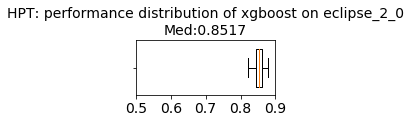

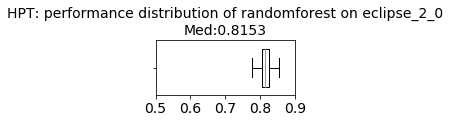

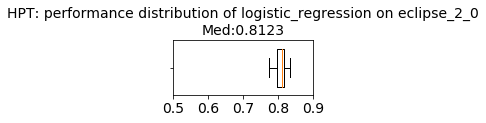

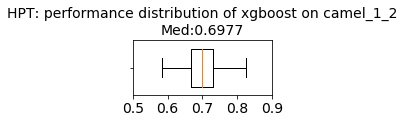

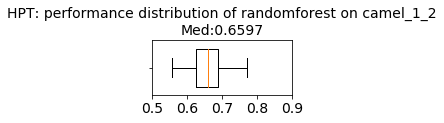

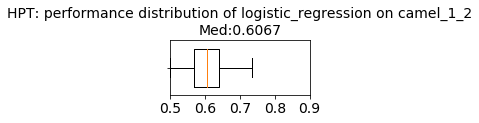

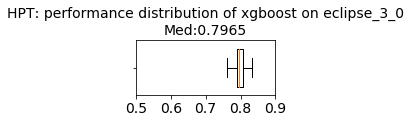

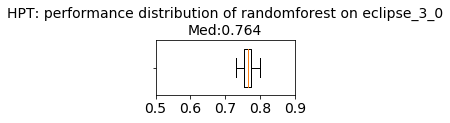

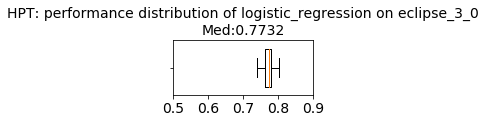

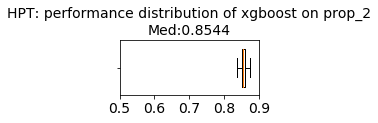

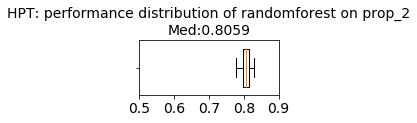

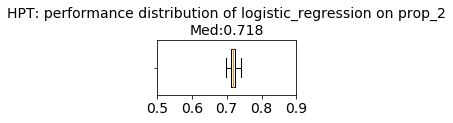

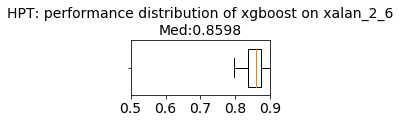

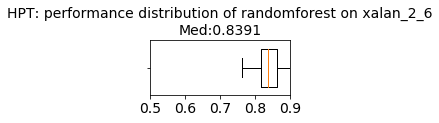

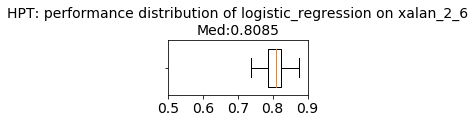

In [59]:
for dataset in dataset_list:
    for algo in algo_list:
        expname = 'H_'+dataset.split('defect_')[1]+'_'+algo
        if algo =='logistic_regression': 
            expname = 'H_'+dataset.split('defect_')[1]+'_lr'
            
        auc_weighted_list = h_auc_map[expname]
        plt.rcParams["figure.figsize"] = (2.5, 1)
        fig1, ax1 = plt.subplots()
        title = 'HPT: performance distribution of '+algo+' on '+dataset.split("defect_")[1]

        #print(title)
        bp_dict = ax1.boxplot(auc_weighted_list,vert=False,showfliers=False,widths = 0.7)
        plt.xticks(fontsize=14)
        ax1.set_xlim([0.5,0.9])
        ax1.set_yticklabels('')
        ax1.set_title(title+'\n'+'Med:' + str(round(median(auc_weighted_list),4)),fontsize = 14)
        
        #plt.rcParams["figure.figsize"] = (5, 3)
        #fig1, ax1 = plt.subplots()
        #ax1.set_title()
        #bp_dict = ax1.boxplot(auc_weighted_list,vert=False)
        #for line in bp_dict['medians']:
        #    # get position data for median line
        #    x, y = line.get_xydata()[1] # top of median line
        #    # overlay median value
        #    text(x, y, round(x,4),
        #         horizontalalignment='center', fontsize=30) # draw above, centered